<a href="https://colab.research.google.com/github/shradhautk/AI-MICROSCOPY-WORKSHOP/blob/main/DL_for_Microscopy_Data_Labeling_Train_Imgs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL for Microscopy: Data Labeling for Training Images
Prepared by Tommy Wong, with sections adopted from https://towardsdatascience.com/extract-annotations-from-cvat-xml-file-into-mask-files-in-python-bb69749c4dc9

**To run this notebook, click Runtime -> Run all. Make sure to specify filenames and uncomment cells according to instructions.**

---

Import modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

It is important to normalize pixels to between 0 and 1 for training with a neural network. Here is a simple function for normalization of a single image:

In [2]:
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

Download training image and label from GitHub. Mount Google Drive or use `!gdown` instead to access images on Google Drive. Augmentation has to be performed on both images and labels to ensure correspondance.

In [3]:
# Training images
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_1.png'
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_2.png'
# Training labels
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Lab_1.xml'
!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Lab_2.xml'

--2023-06-06 06:47:05--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157118 (153K) [image/png]
Saving to: ‘DL_for_Microscopy_Train_Img_1.png’

DL_for_Microscopy_T 100%[===================>] 153.44K  --.-KB/s    in 0.02s   

2023-06-06 06:47:05 (6.19 MB/s) - ‘DL_for_Microscopy_Train_Img_1.png’ saved [157118/157118]

--2023-06-06 06:47:06--  https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/Data_Augmentation/DL_for_Microscopy_Train_Img_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting t

Load, normalize, and show the training image and labels with size 512 by 512. The images have dimensions [N, H, W] where N is the number of images. Define a function that does that.

In [4]:
# A function to generate a stack of images:
def get_imgs(file_list):
    imgs_ = []
    for name in file_list:
        imgs_.append(norm2D(plt.imread(name)))
    # move last axis to 1st so that 1st axis is no. of imgs
    return np.moveaxis(np.dstack(imgs_), -1, 0)

**Create a python list of your training images filenames here:**

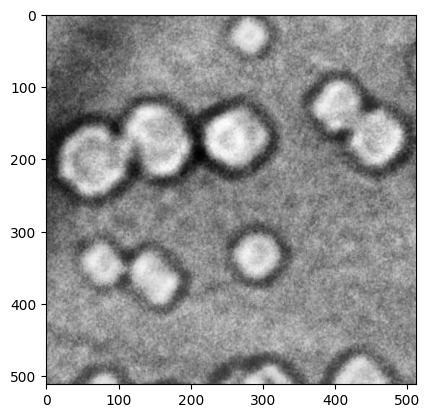

In [30]:
# Change the filenames of this list to your training data:
train_img_names = ['DL_for_Microscopy_Train_Img_1.png', 'DL_for_Microscopy_Train_Img_2.png']

# Generate a stack of training images:
train_imgs = get_imgs(train_img_names)

# Show the training imgs:
plt.imshow(train_imgs[0], cmap='gist_gray') 
plt.imshow(train_imgs[1], cmap='gist_gray') 

Define a function to parse the `.xml` files. Takes image and labels filenames as lists and returns a list of annotations.

In [6]:
#@title `.xml` parser
from lxml import etree

def parse_anno_file(cvat_xml, image_name):
    annos = []
    for i in range(len(cvat_xml)):
        root = etree.parse(cvat_xml[i]).getroot()
        anno = []
        image_name_attr = ".//image[@name='{}']".format(image_name[i])
        for image_tag in root.iterfind(image_name_attr):
                image = {}
                for key, value in image_tag.items():
                    image[key] = value
                image['shapes'] = []
                for poly_tag in image_tag.iter('polygon'):
                    polygon = {'type': 'polygon'}
                    for key, value in poly_tag.items():
                        polygon[key] = value
                    image['shapes'].append(polygon)
                for ell_tag in image_tag.iter('ellipse'):
                    ellipse = {'type': 'ellipse'}
                    for key, value in ell_tag.items():
                        ellipse[key] = value
                    image['shapes'].append(ellipse)
                for box_tag in image_tag.iter('box'):
                    box = {'type': 'box'}
                    for key, value in box_tag.items():
                        box[key] = value
                    box['points'] = "{0},{1};{2},{1};{2},{3};{0},{3}".format(
                        box['xtl'], box['ytl'], box['xbr'], box['ybr'])
                    image['shapes'].append(box)
                image['shapes'].sort(key=lambda x: int(x.get('z_order', 0)))
                anno.append(image)
        annos.append(anno)
    return annos

Parse the `.xml` file and show a sample annotation. **Type your image and labels filenames as lists.**

In [7]:
xml = ['DL_for_Microscopy_Train_Lab_1.xml', 'DL_for_Microscopy_Train_Lab_2.xml']
annos = parse_anno_file(xml, train_img_names)
print(annos[0][0]) #[0][0] since there is only 1 img

{'id': '0', 'name': 'DL_for_Microscopy_Train_Img_1.png', 'width': '512', 'height': '512', 'shapes': [{'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '190.29,53.06;190.29,41.21;190.91,31.86;186.55,23.12;177.19,16.26;167.21,13.77;157.23,11.90;147.25,11.27;137.90,12.52;129.16,16.26;120.43,21.25;114.82,29.36;111.07,38.09;111.07,48.70;114.82,57.43;119.81,66.16;127.29,72.40;136.02,76.14;145.38,77.39;154.74,78.64;164.09,78.01;172.83,73.65;183.40,64.30', 'z_order': '0'}, {'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '99.85,57.43;96.10,48.70;94.86,39.34;97.97,29.99;101.09,20.63;108.58,14.39;117.94,13.14;127.29,11.27;137.27,11.27;146.00,15.02;154.74,18.76;162.22,25.00;164.09,34.35;162.22,43.71;157.23,52.44;152.24,61.17;146.63,69.91;136.02,76.77;127.90,76.10;118.56,73.02;106.10,66.20', 'z_order': '0'}, {'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '1.29,58.05;10.65,59.93;20.01,63.

Define functions that generate masks and datasets for U-Net and Mask R-CNN:

In [27]:
#@title Functions that generate masks and datasets for U-Net and Mask R-CNN
# must include these modules for functions below
import cv2
import torch

# Creates a mask using parsed annotations. Can be used directly to create mask for U-Net
def create_mask(width, height, shapes):
    mask = np.zeros((height, width), dtype=np.uint8)
    for shape in shapes:
        if shape['type'] == 'polygon':
            points = [tuple(map(float, p.split(','))) for p in shape['points'].split(';')]
            points = np.array([(int(p[0]), int(p[1])) for p in points])
            points = points.astype(int)
            mask = cv2.drawContours(mask, [points], -1, color=1, thickness=-1)
        if shape['type'] == 'ellipse':
            center_coordinates = (int(float(shape['cx'])), int(float(shape['cy'])))
            axesLength = (int(float(shape['rx'])), int(float(shape['ry'])))
            if 'rotation' in shape:
                angle = int(shape['rotation'])
            else:
                angle = 0
            mask = cv2.ellipse(mask, center_coordinates, axesLength, angle, 
                               startAngle=0, endAngle=360, color=1, thickness=-1)
    return mask

# Create mask for U-Net -> [N, H, W]
def get_unet_mask(annos):
    masks = []
    for anno in annos:
        mask = create_mask(int(anno[0]['width']), int(anno[0]['height']), anno[0]['shapes'])
        masks.append(mask)
    masks_np = np.dstack(masks)
    return np.moveaxis(masks_np, -1, 0)

# Creates bounding boxes
# masks shape = [N, H, W]
def boundbox(masks, maxDim):    # bounding boxes [x1 y1 x2 y2]
    num_objs = len(masks)   
    boxes = np.zeros((num_objs, 4))
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes[i, ...] = np.array([xmin, ymin, xmax, ymax])
    
    boxes[boxes < 0] = 0 # set negative values to 0
    boxes[boxes > maxDim-1] = maxDim-1 # set values larger than image size to max
    # check for bounding boxes with area != 0:
    boolMask = (boxes[:, 0] != boxes[:, 2]) & (boxes[:, 1] != boxes[:, 3])
    # select masks and boxes with area != 0:
    return torch.as_tensor(boxes[boolMask], dtype=torch.float32), masks[boolMask]

# Generate masks for Mask R-CNN from parsed .xml annotations
# return [N, H, W, C] where N is the no. of images
# and C is the number of features (masks) in each image
def get_maskrcnn_mask(annos):
    single_masks = []
    height = int(annos[0][0]['height']); width = int(annos[0][0]['width'])
    for a in range(len(annos)):
        num_masks = len(annos[a][0]['shapes'])
        single_mask = np.zeros((height, width, num_masks), np.uint8)
        for i in range(num_masks):
            single_mask[..., i] = create_mask(width, height, [annos[a][0]['shapes'][i]])
        single_masks.append(single_mask)
    return single_masks

# Create the dataset in the format [target{boxes, labels, masks}...] and 
# valid images in the format [N, H, W]. [target...] has N entries, each target 
# has C entries for C features in a single image. labels are int tensor with C entries
# for C features. masks have shape [C, H, W]. boxes have shape [C, 4], each row 
# is [x1 y1 x2 y2].
# inputs: images, labels are in np.array([N, H, W, (C)]) where N is the no. of images
# labels have C for the number of features (masks) in each image
# maskdim (int) is the size of the square masks == size of images
def get_maskrcnn_dataset(images, labels):
    train_Y = []
    invalid_imgs = []
    maskdim = images.shape[1]
    for i in range(images.shape[0]):
        box_labs = np.moveaxis(labels[i], -1, 0)
        boundboxes, updatedMasks = boundbox(box_labs, maskdim)
        # check for imgs w/o bounding boxes, skip processing and get idx
        if np.any(boundboxes.cpu().detach().numpy()) == False:
            print(f'invalid image: {i}')
            invalid_imgs.append(i)
            continue
        target = {}
        target["boxes"] = boundboxes
        target["labels"] = torch.as_tensor(np.ones(len(boundboxes)), dtype=torch.int64)        
        target["masks"] = torch.as_tensor(updatedMasks, dtype=torch.uint8)
        if len(target["boxes"]) == len(target["labels"]) == len(target["masks"]):
            train_Y.append(target)
            print(f'image {i} has {len(boundboxes)} boxes')
        else:
            print('dictionary entries lengths do not match')
            break
    # select only images with labels
    valid_images = np.delete(images, invalid_imgs, axis=0)
    return valid_images, train_Y

## Process data for U-Net

Generate the labels for U-Net semantic segmentation. Masks have dimensions [N, H, W] and pixel values of either 0 (for background) and 1 (for features).

In [9]:
unet_masks = get_unet_mask(annos)

Show the U-Net mask:

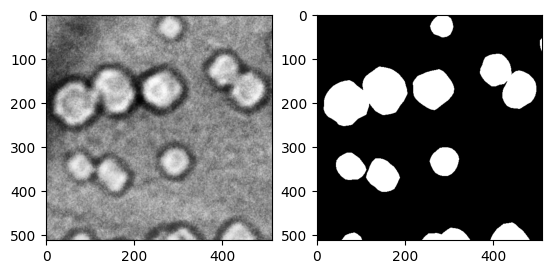

In [31]:
#@title Show the mask:

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_imgs[1], cmap='gist_gray')
ax[1].imshow(unet_masks[1], cmap='gist_gray')

Mount Google drive to save. **Uncomment entire cell to mount Google Drive. Type the path to your save directory below.**

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
directory = '/content/drive/Shared drives/Bredesen Center ESE PhD/Conferences/Deep Learning for Microscopy Image Analysis in Nuclear Materials 2023'
os.chdir(directory)

Mounted at /content/drive


Save the images and masks as numpy files for easy manipulation. **Uncomment entire cell to save processed images and masks. Change the filenames below.**

In [12]:
np.save('DL_for_Microscopy_Train_Img_12', train_imgs)
np.save('DL_for_Microscopy_Train_Img_12_unet_mask', unet_masks)

## Process data for Mask R-CNN

Generate the labels for U-Net semantic segmentation. Masks have dimensions [N, H, W, C] where N is the no. of images and C is the number of features (masks) in each image, and pixel values of either 0 (for background) and 1 (for features).

In [28]:
maskRcnn_masks = get_maskrcnn_mask(annos)

Show the Mask R-CNN mask:

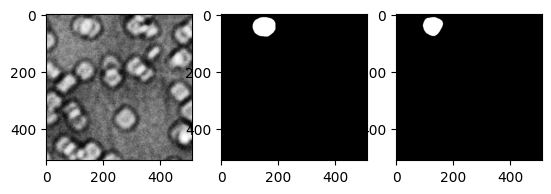

In [32]:
#@title Show the mask:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(train_imgs[0], cmap='gist_gray')
ax[1].imshow(maskRcnn_masks[0][...,0], cmap='gist_gray')
ax[2].imshow(maskRcnn_masks[0][...,1], cmap='gist_gray')

Save the images and masks as pickle files for easy manipulation. **Uncomment entire cell to save processed images and masks. Change the filenames below.**

In [35]:
import pickle
with open('DL_for_Microscopy_Train_Img_12_maskRcnn_mask.pickle', 'wb') as f:
    pickle.dump(maskRcnn_masks, f)
f.close()

Using the masks we just created, create the dataset in the format [target{boxes, labels, masks}...] and valid images in the format [N, H, W]. [target...] has N entries, each target has C entries for C features in a single image. labels are int tensor with C entries for C features. masks have shape [C, H, W]. boxes have shape [C, 4], each row is [x1 y1 x2 y2]. Inputs: images, labels are in np.array([N, H, W, (C)]) where N is the no. of images and labels have C for the number of features (masks) in each image.

In [33]:
train_imgs, maskRcnn_labels = get_maskrcnn_dataset(images=train_imgs, labels=maskRcnn_masks)

image 0 has 37 boxes
image 1 has 14 boxes


Show the bounding boxes:

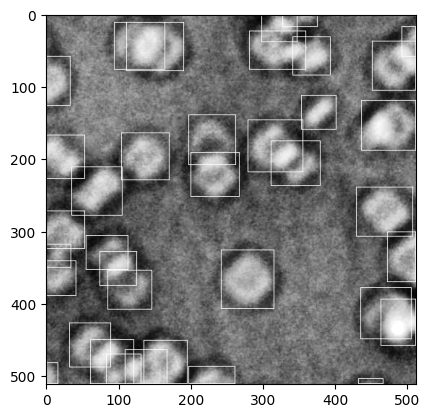

In [34]:
#@title Show drawn boxes:
import cv2
drawn_img = np.copy(train_imgs[0])
for i in range(len(maskRcnn_labels[0]["boxes"])):
    pred2Dboxed = cv2.rectangle(drawn_img, 
                                maskRcnn_labels[0]["boxes"].numpy()[i, 0:2].astype(int), 
                                maskRcnn_labels[0]["boxes"].numpy()[i, 2:4].astype(int), color=1)
plt.imshow(pred2Dboxed, cmap = 'gist_gray')

Mount Google drive to save. **Uncomment entire cell to mount Google Drive. Type the path to your save directory below.**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#directory = 'path to your Google drive directory here'
#os.chdir(directory)

Save the images as numpy files for easy manipulation. The labels have to be saved as `.pickle` files due to the data structure. **Uncomment entire cell to save processed images and masks. Change the filenames below.**

In [ ]:
# Save processed images
#np.save('DL_for_Microscopy_Train_eg_img', train_imgs)
# Save Mask R-CNN dataset
#import pickle
#with open('DL_for_Microscopy_Train_eg_img_maskRcnn_data.pickle', 'wb') as f:
#    pickle.dump(maskRcnn_labels, f)
#f.close()